In [12]:
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
rcParams['figure.figsize'] = 20, 6
set_matplotlib_formats('retina')

from datetime import datetime
import pandas as pd
import numpy as np

import warnings; warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import svm,linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from skgarden import RandomForestQuantileRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

def load_series(data_path, file, params):
    df = pd.read_csv(data_path + file,
                 parse_dates={'date' : [params['column_sort']]}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col=['date'])
    return df

file = 'smart_meters_london_cleaned_same_start_with_weather_example.csv'
data_path = '/Users/dimitriskemos/Desktop/Data/'
params = {'column_sort': 'date_time'}

df = load_series(data_path,file, params)

df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')

In [13]:
df.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,id,energy
date,,,,,,,,,,
2013-10-30 00:00:00+01:00,14.31,244,6.86,4.61,1017.98,4.55,3.29,0.86,MAC000002,0.457
2013-10-30 01:00:00+01:00,14.31,238,6.10,4.09,1018.38,3.86,2.95,0.87,MAC000002,0.414
2013-10-30 02:00:00+01:00,13.45,247,5.94,4.17,1018.89,3.54,3.14,0.88,MAC000002,0.408
2013-10-30 03:00:00+01:00,13.23,249,5.54,3.92,1019.25,3.13,3.02,0.89,MAC000002,0.352
2013-10-30 04:00:00+01:00,14.31,242,5.06,3.28,1019.57,2.78,2.74,0.88,MAC000002,0.250


In [3]:
h_params = {'n_in': 24 * 28, 'n_out': 24, 'step_foreward': 24, 'column_value': 'energy'}
date_train_start =  datetime.strptime('2013-12-31 00:00:00', '%Y-%m-%d %H:%M:%S')
df = df[df.index >= date_train_start]

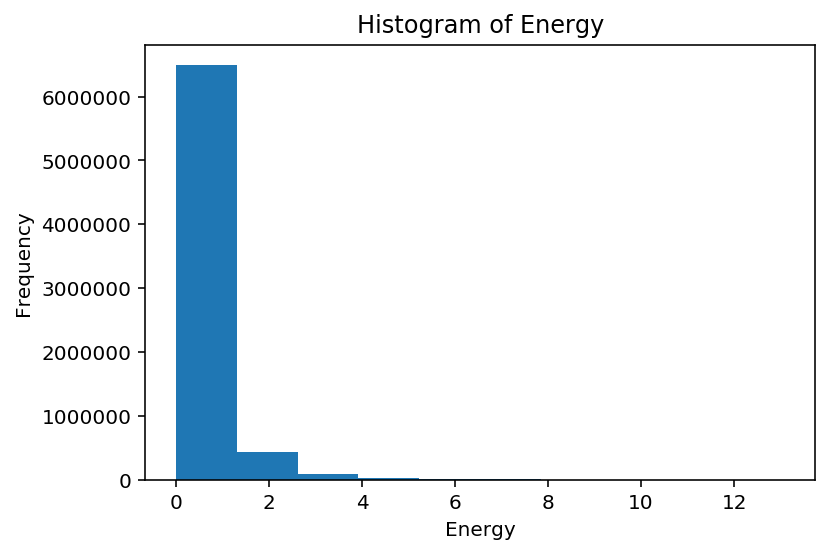

In [4]:
# histogram of energy consumption
plt.hist(df['energy'])
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title("Histogram of Energy")
plt.show()

In [5]:
df['energylog'] = np.log1p(df['energy'])

In [6]:
df.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,id,energy,energylog
date,,,,,,,,,,,
2013-12-31 00:00:00+01:00,11.46,170,6.82,4.94,1012.35,4.62,3.10,0.88,MAC000002,0.888,0.635518
2013-12-31 01:00:00+01:00,11.41,162,6.92,5.43,1011.76,4.62,3.29,0.90,MAC000002,0.894,0.638691
2013-12-31 02:00:00+01:00,11.57,161,7.50,6.02,1010.82,5.19,3.52,0.90,MAC000002,0.312,0.271553
2013-12-31 03:00:00+01:00,11.96,161,8.11,6.31,1009.59,5.92,3.53,0.88,MAC000002,0.219,0.198031
2013-12-31 04:00:00+01:00,12.26,161,8.72,7.08,1008.74,6.14,4.63,0.89,MAC000002,0.218,0.197210


# QANTILE RANDOM FORESTS

## Baseline Model

sMAPE 35.41292339820931
MAPE 114.32767947556619


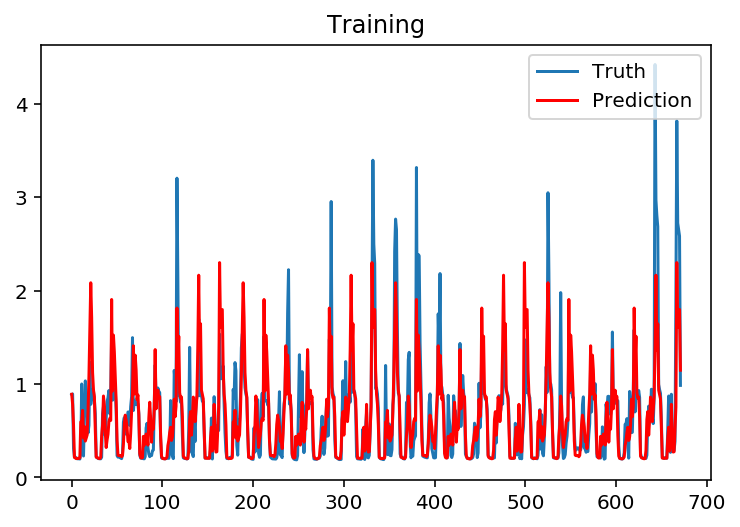

In [7]:
df_energy = df[['energy']]
df_energy['hour'] = df_energy.index.hour
df_energy['weekday'] = df_energy.index.weekday

X_train = df_energy[:h_params['n_in']][['hour', 'weekday']]
y_train = df_energy[:h_params['n_in']][['energy']]

rfqr = RandomForestQuantileRegressor(random_state=0)
rfqr.fit(X_train, y_train)
yHat_train = rfqr.predict(X_train)

def smape(yHat, y):
    return np.mean(np.abs((yHat - y) / (y + yHat))) * 100

def mape(yHat, y):
    return np.mean(np.abs((y - yHat) / y)) * 100

print ('sMAPE' , smape(yHat_train, y_train.values))

print ('MAPE', mape(yHat_train,y_train.values))

plt.plot(y_train['energy'].values)
plt.plot(yHat_train, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Training")
plt.show()


In [6]:
from sklearn.metrics import r2_score
r2_score(y_train.values, yHat_train)

0.6335151754880872

In [7]:
from sklearn.metrics import median_absolute_error
median_absolute_error(y_train.values, yHat_train)


0.10069837301587298

In [8]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train.values, yHat_train)

0.190949112360833

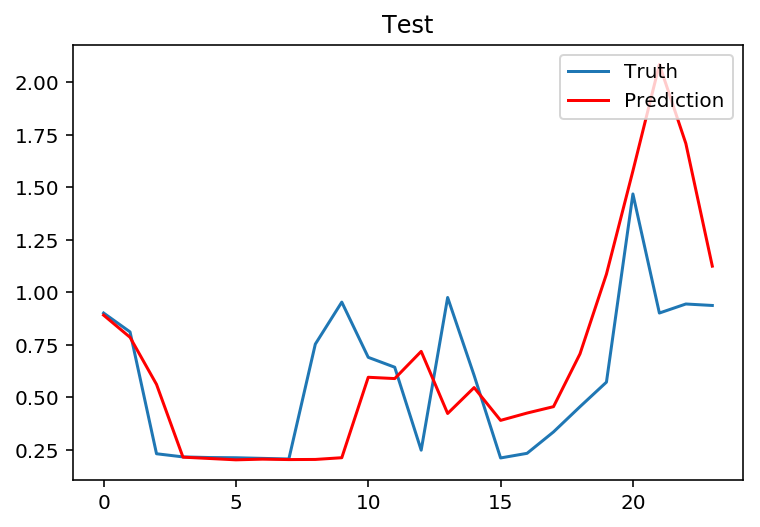

In [8]:
X_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['hour', 'weekday']]
y_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['energy']]
yHat_test = rfqr.predict(X_test)

smape(yHat_test, y_test.values)

plt.plot(y_test['energy'].values)
plt.plot(yHat_test, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Test")
plt.show()

In [9]:
rfqr = RandomForestQuantileRegressor(random_state=0)
rfqr.fit(X_train, y_train)
yHat_train = rfqr.predict(X_train)

def smape(yHat, y):
    return np.mean(np.abs((yHat - y) / (y + yHat))) * 100

smape(yHat_train, y_train.values)

35.41292339820931

## Rolling Forecast

In [10]:
def prepare_train_test(df, y, features, n_in, n_out, current_step, step_foreward):
    step = current_step * step_foreward
    start_train = step
    end_train = n_in + step
    X_train = df[start_train:end_train][features]
    y_train = df[start_train:end_train][y]
    
    start_test = end_train
    end_test = start_test + n_out
    X_test = df[start_test:end_test][features]
    y_test = df[start_test:end_test][y]
    return X_train, y_train, X_test, y_test

def n_possible_steps(df, n_in, n_out, step_foreward):
    timesteps = df.shape[0]
    return int((timesteps - n_in - n_out) / step_foreward)


def rolling_forecast_experiment(df, y, features, n_in, n_out, step_foreward): 
    n_steps = n_possible_steps(df, n_in, n_out, step_foreward)
    
    smape_values = []
    for i in range(0, n_steps):
        rfqr = RandomForestQuantileRegressor(random_state=0)
        X_train, y_train, X_test, y_test = prepare_train_test(df, y, features, n_in, n_out, i, step_foreward)
        rfqr.fit(X_train, y_train)
        yHat = rfqr.predict(X_test)
        smape_values.append(smape(yHat, y_test.values))
    return smape_values

### Quantile Random Forest Model

In [11]:
#Parameters for rolling forecast
y = ['energy']
features = ['hour', 'weekday']
n_in = h_params['n_in']
n_out = h_params['n_out'] 

#Perform Rolling Forecast 
smape_values = rolling_forecast_experiment(df_energy, y, features, n_in, n_out, n_out)
np.median(smape_values)

KeyboardInterrupt: 

###  Multivariate Quantile Random Forest Model

In [13]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,id,energy,hour,weekday
date,,,,,,,,,,,,
2013-12-31 00:00:00+01:00,11.46,170,6.82,4.94,1012.35,4.62,3.10,0.88,MAC000002,0.888,0,1
2013-12-31 01:00:00+01:00,11.41,162,6.92,5.43,1011.76,4.62,3.29,0.90,MAC000002,0.894,1,1
2013-12-31 02:00:00+01:00,11.57,161,7.50,6.02,1010.82,5.19,3.52,0.90,MAC000002,0.312,2,1
2013-12-31 03:00:00+01:00,11.96,161,8.11,6.31,1009.59,5.92,3.53,0.88,MAC000002,0.219,3,1
2013-12-31 04:00:00+01:00,12.26,161,8.72,7.08,1008.74,6.14,4.63,0.89,MAC000002,0.218,4,1


In [14]:
y = ['energy']
features = ['hour', 'weekday', 'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure', 'apparentTemperature', 'windSpeed', 'humidity']
n_in = h_params['n_in']
n_out = h_params['n_out']

# Perform Rolling Forecast 
smape_values = rolling_forecast_experiment(df, y, features, n_in, n_out, n_out)
np.median(smape_values)

35.01954147672926

# Kernel Ridge Regression

18.64250096536558


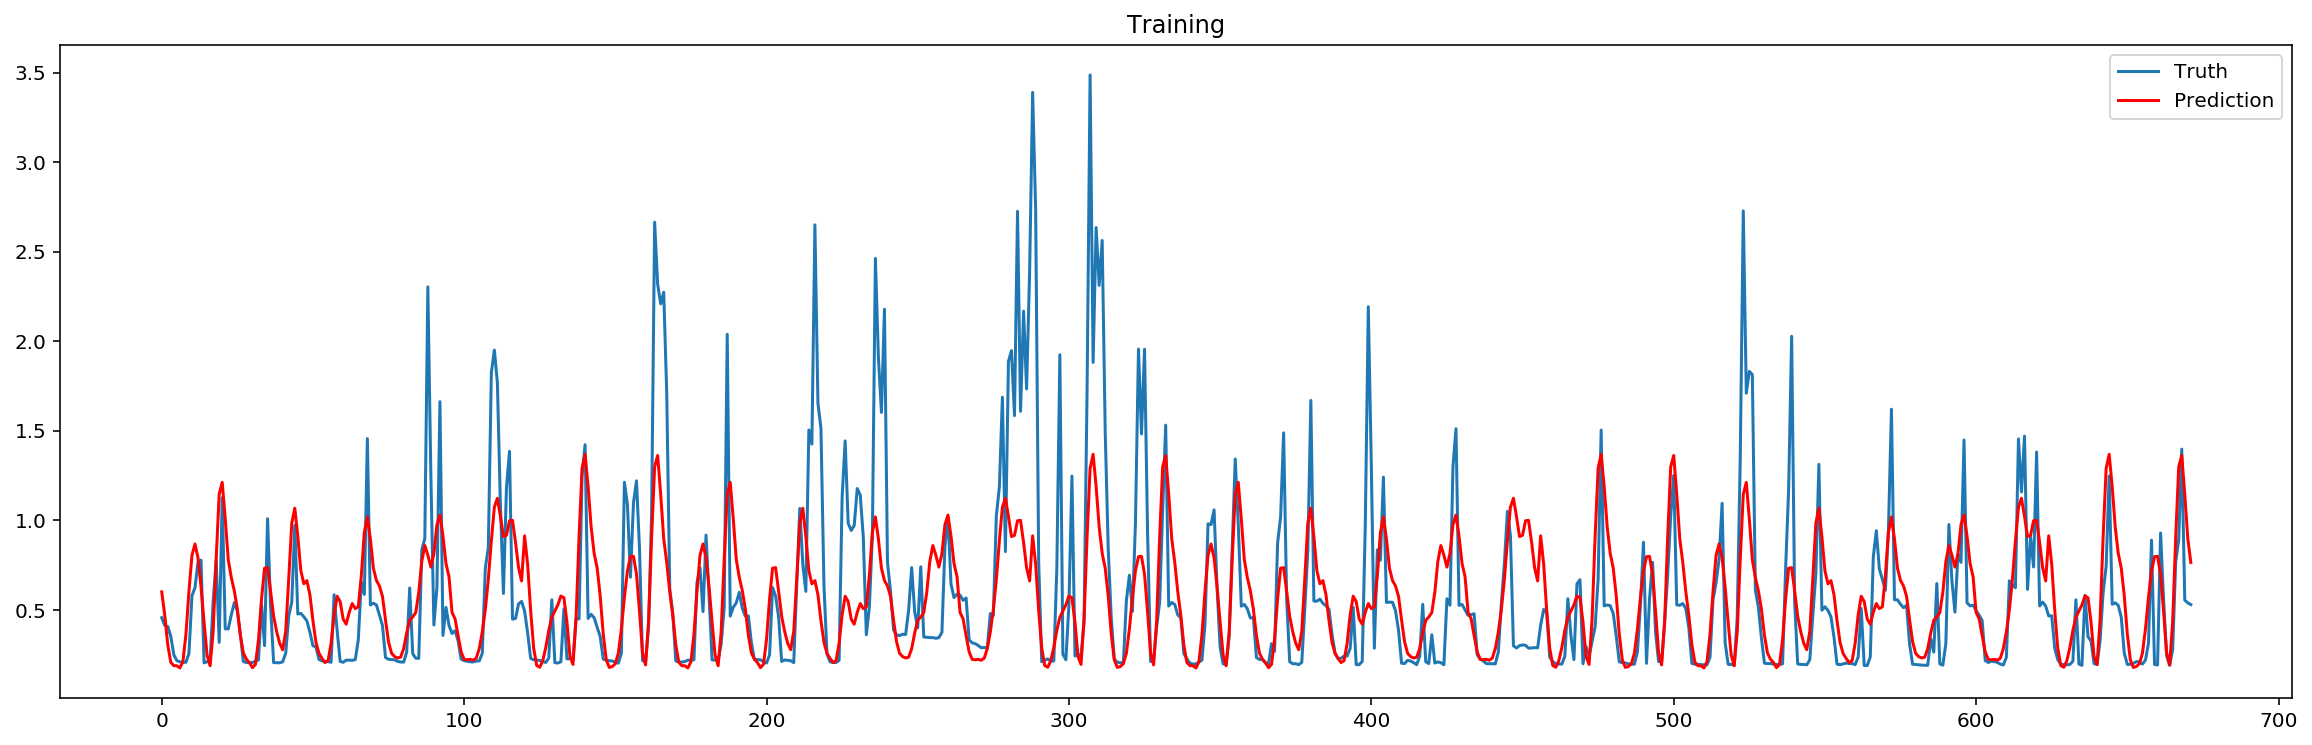

In [34]:
df_energy = df[['energy']]
df_energy['hour'] = df_energy.index.hour
df_energy['weekday'] = df_energy.index.weekday

X_train = df_energy[:h_params['n_in']][['hour', 'weekday']]
y_train = df_energy[:h_params['n_in']][['energy']]

kernelridge = KernelRidge(kernel='rbf', gamma=0.1)
kernelridge.fit(X_train, y_train)
yHat_train = kernelridge.predict(X_train)

def smape(yHat, y):
    return np.mean(np.abs((yHat - y) / (y + yHat))) * 100

print (smape(yHat_train, y_train.values))

plt.plot(y_train['energy'].values)
plt.plot(yHat_train, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Training")
plt.show()

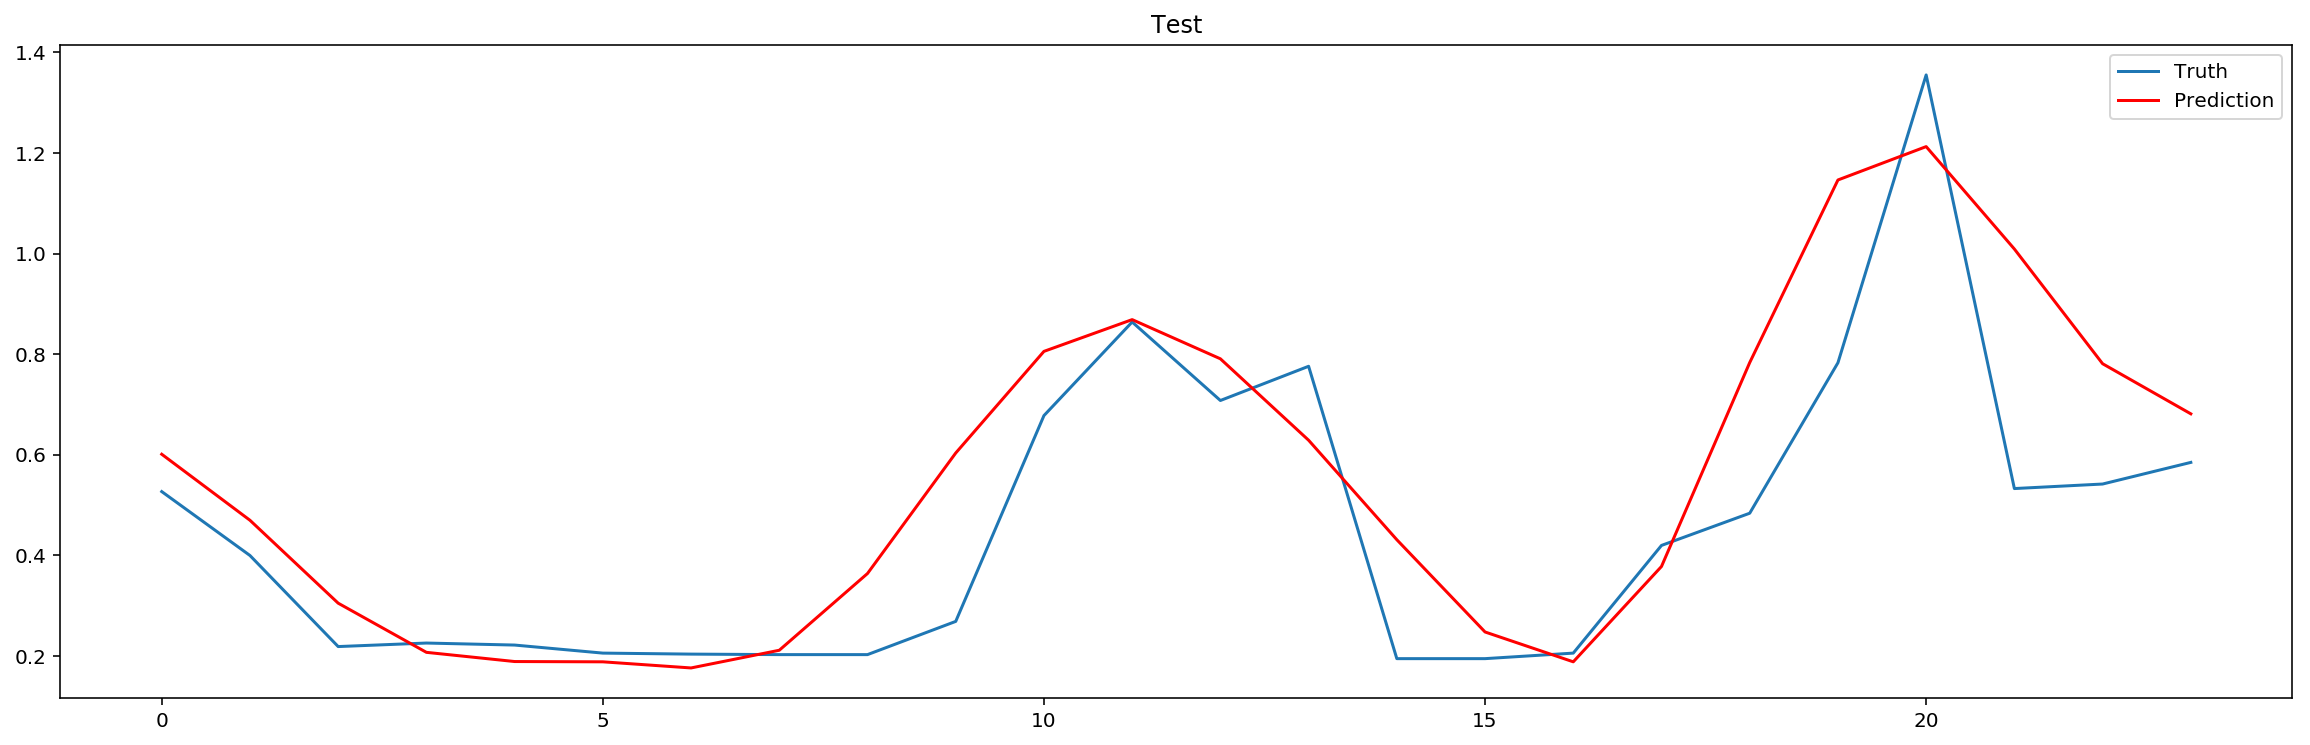

In [35]:
X_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['hour', 'weekday']]
y_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['energy']]
yHat_test = kernelridge.predict(X_test)

smape(yHat_test, y_test.values)

plt.plot(y_test['energy'].values)
plt.plot(yHat_test, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Test")
plt.show()

In [17]:
kernelridge = KernelRidge(kernel='rbf', gamma=0.1)
kernelridge.fit(X_train, y_train)
yHat_train = kernelridge.predict(X_train)

def smape(yHat, y):
    return np.mean(np.abs((yHat - y) / (y + yHat))) * 100

smape(yHat_train, y_train.values)

15.4205580116803

### Rolling Forecast 

In [18]:
def prepare_train_test(df, y, features, n_in, n_out, current_step, step_foreward):
    step = current_step * step_foreward
    start_train = step
    end_train = n_in + step
    X_train = df[start_train:end_train][features]
    y_train = df[start_train:end_train][y]
    
    start_test = end_train
    end_test = start_test + n_out
    X_test = df[start_test:end_test][features]
    y_test = df[start_test:end_test][y]
    return X_train, y_train, X_test, y_test

def n_possible_steps(df, n_in, n_out, step_foreward):
    timesteps = df.shape[0]
    return int((timesteps - n_in - n_out) / step_foreward)


def rolling_forecast_experiment(df, y, features, n_in, n_out, step_foreward): 
    n_steps = n_possible_steps(df, n_in, n_out, step_foreward)
    
    smape_values = []
    for i in range(0, n_steps):
        kernelridge = KernelRidge(kernel='rbf', gamma=0.1)
        X_train, y_train, X_test, y_test = prepare_train_test(df, y, features, n_in, n_out, i, step_foreward)
        kernelridge.fit(X_train, y_train)
        yHat = kernelridge.predict(X_test)
        smape_values.append(smape(yHat, y_test.values))
    return smape_values

In [19]:
#Parameters for rolling forecast
y = ['energy']
features = ['hour', 'weekday']
n_in = h_params['n_in']
n_out = h_params['n_out'] 

#Perform Rolling Forecast 
smape_values = rolling_forecast_experiment(df_energy, y, features, n_in, n_out, n_out)
np.median(smape_values)

16.984559916011776

# SUPPORT VECTOR REGRESSION
Support Vector Machine can also be used as a regression method, maintaining all the main features that characterize the algorithm (maximal margin). The Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. First of all, because output is a real number it becomes very difficult to predict the information at hand, which has infinite possibilities. In the case of regression, a margin of tolerance (epsilon) is set in approximation to the SVM which would have already requested from the problem. But besides this fact, there is also a more complicated reason, the algorithm is more complicated therefore to be taken in consideration. However, the main idea is always the same: to minimize error, individualizing the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated. 

In [ ]:
# hyperparameter selection for SVR

from sklearn import grid_search, svm

def svc_param_selection(X, y, nfolds):
    Cs = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,1,10]
    gammas = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1, 10]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVR(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X_train, y_train)
    grid_search.best_params_
    return grid_search.best_params_

print ('HyperParameters SVR' , svc_param_selection(X_train, y_train,2))

sMAPE 34.17391611680816


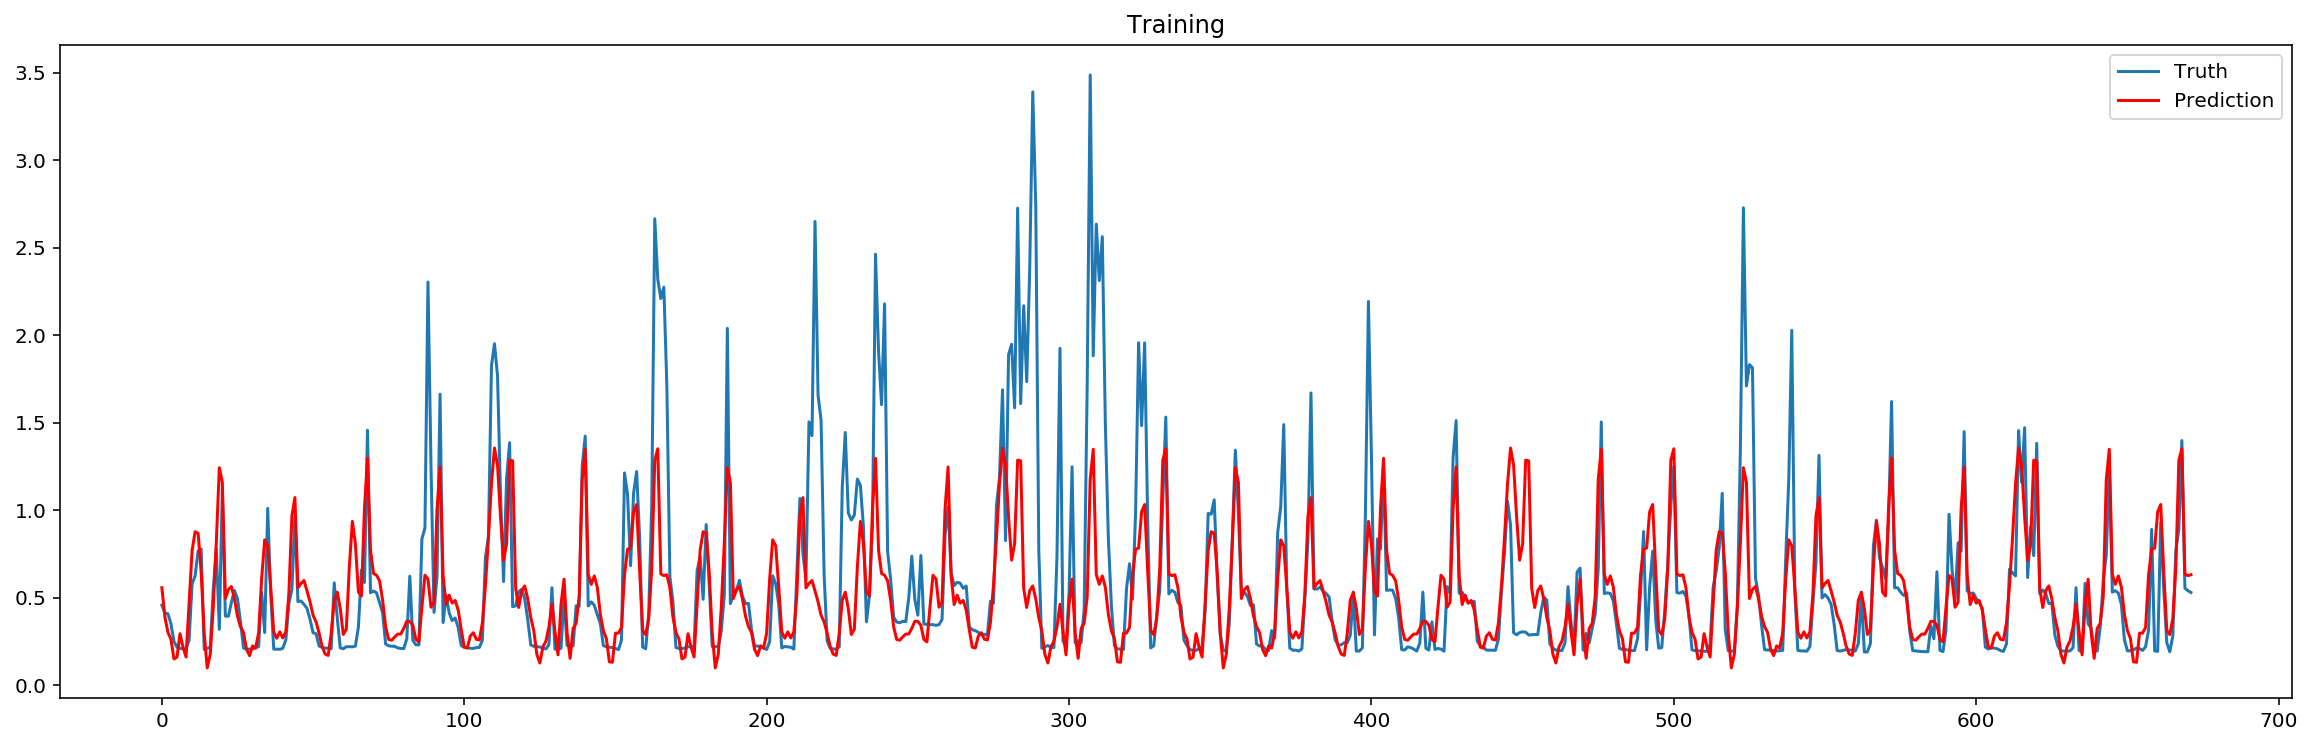

In [22]:
from sklearn.svm import SVR

df_energy = df[['energy']]
df_energy['hour'] = df_energy.index.hour
df_energy['weekday'] = df_energy.index.weekday

X_train = df_energy[:h_params['n_in']][['hour', 'weekday']]
y_train = df_energy[:h_params['n_in']][['energy']]

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(X_train, y_train)
yHat_train_svr = svr_rbf.predict(X_train)

def smape(yHat, y):
    return np.mean(np.abs((yHat - y) / (y + yHat))) * 100

def mape(yHat, y):
    return np.mean(np.abs((y - yHat) / y)) * 100

print ('sMAPE' , smape(yHat_train, y_train.values))

plt.plot(y_train['energy'].values)
plt.plot(yHat_train_svr, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Training")
plt.show()


In [21]:
X_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['hour', 'weekday']]
y_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['energy']]
yHat_test_svr = kernelridge.predict(X_test)

smape(yHat_test_svr, y_test.values)

plt.plot(y_test['energy'].values)
plt.plot(yHat_test_svr, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Test")
plt.show()



NameError: name 'kernelridge' is not defined

In [22]:
def prepare_train_test(df, y, features, n_in, n_out, current_step, step_foreward):
    step = current_step * step_foreward
    start_train = step
    end_train = n_in + step
    X_train = df[start_train:end_train][features]
    y_train = df[start_train:end_train][y]
    
    start_test = end_train
    end_test = start_test + n_out
    X_test = df[start_test:end_test][features]
    y_test = df[start_test:end_test][y]
    return X_train, y_train, X_test, y_test

def n_possible_steps(df, n_in, n_out, step_foreward):
    timesteps = df.shape[0]
    return int((timesteps - n_in - n_out) / step_foreward)


def rolling_forecast_experiment(df, y, features, n_in, n_out, step_foreward): 
    n_steps = n_possible_steps(df, n_in, n_out, step_foreward)
    
    smape_values = []
    for i in range(0, n_steps):
        svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
        X_train, y_train, X_test, y_test = prepare_train_test(df, y, features, n_in, n_out, i, step_foreward)
        svr_rbf.fit(X_train, y_train)
        yHat = svr_rbf.predict(X_test)
        smape_values.append(smape(yHat, y_test.values))
    return smape_values

In [23]:
#Parameters for rolling forecast
y = ['energy']
features = ['hour', 'weekday']
n_in = h_params['n_in']
n_out = h_params['n_out'] 

#Perform Rolling Forecast 
smape_values = rolling_forecast_experiment(df_energy, y, features, n_in, n_out, n_out)
np.median(smape_values)

35.08428043659365

In [24]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday

y = ['energy']
features = ['hour', 'weekday', 'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure', 'apparentTemperature', 'windSpeed', 'humidity']
n_in = h_params['n_in']
n_out = h_params['n_out']

# Perform Rolling Forecast 
smape_values = rolling_forecast_experiment(df, y, features, n_in, n_out, n_out)
np.median(smape_values)

31.365354571379548

# GRADIENT BOOSTING REGRESSION

sMAPE 33.511639417780025


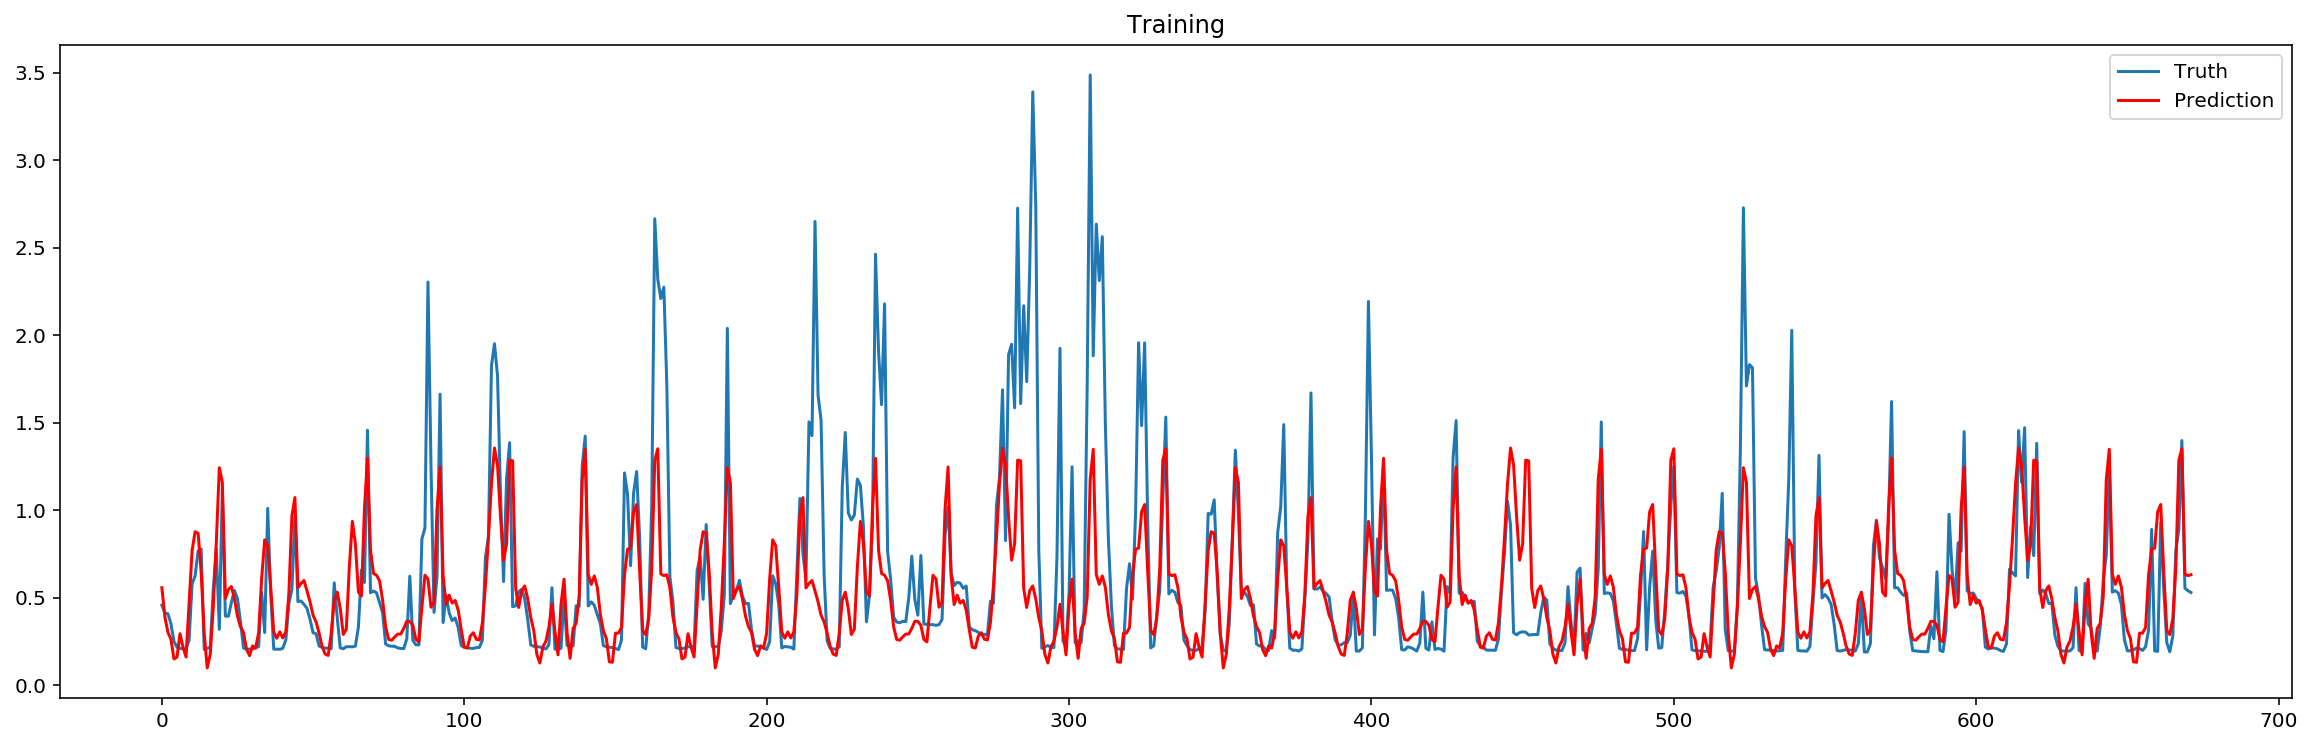

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

df_energy = df[['energy']]
df_energy['hour'] = df_energy.index.hour
df_energy['weekday'] = df_energy.index.weekday

X_train = df_energy[:h_params['n_in']][['hour', 'weekday']]
y_train = df_energy[:h_params['n_in']][['energy']]

gbrt=GradientBoostingRegressor(n_estimators=100)
gbrt.fit(X_train, y_train)
yHat_train_gbrt = gbrt.predict(X_train)

def smape(yHat, y):
    return np.mean(np.abs((yHat - y) / (y + yHat))) * 100

def mape(yHat, y):
    return np.mean(np.abs((y - yHat) / y)) * 100

print ('sMAPE' , smape(yHat_train_gbrt, y_train.values))

plt.plot(y_train['energy'].values)
plt.plot(yHat_train_svr, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Training")
plt.show()


30.616434981694496


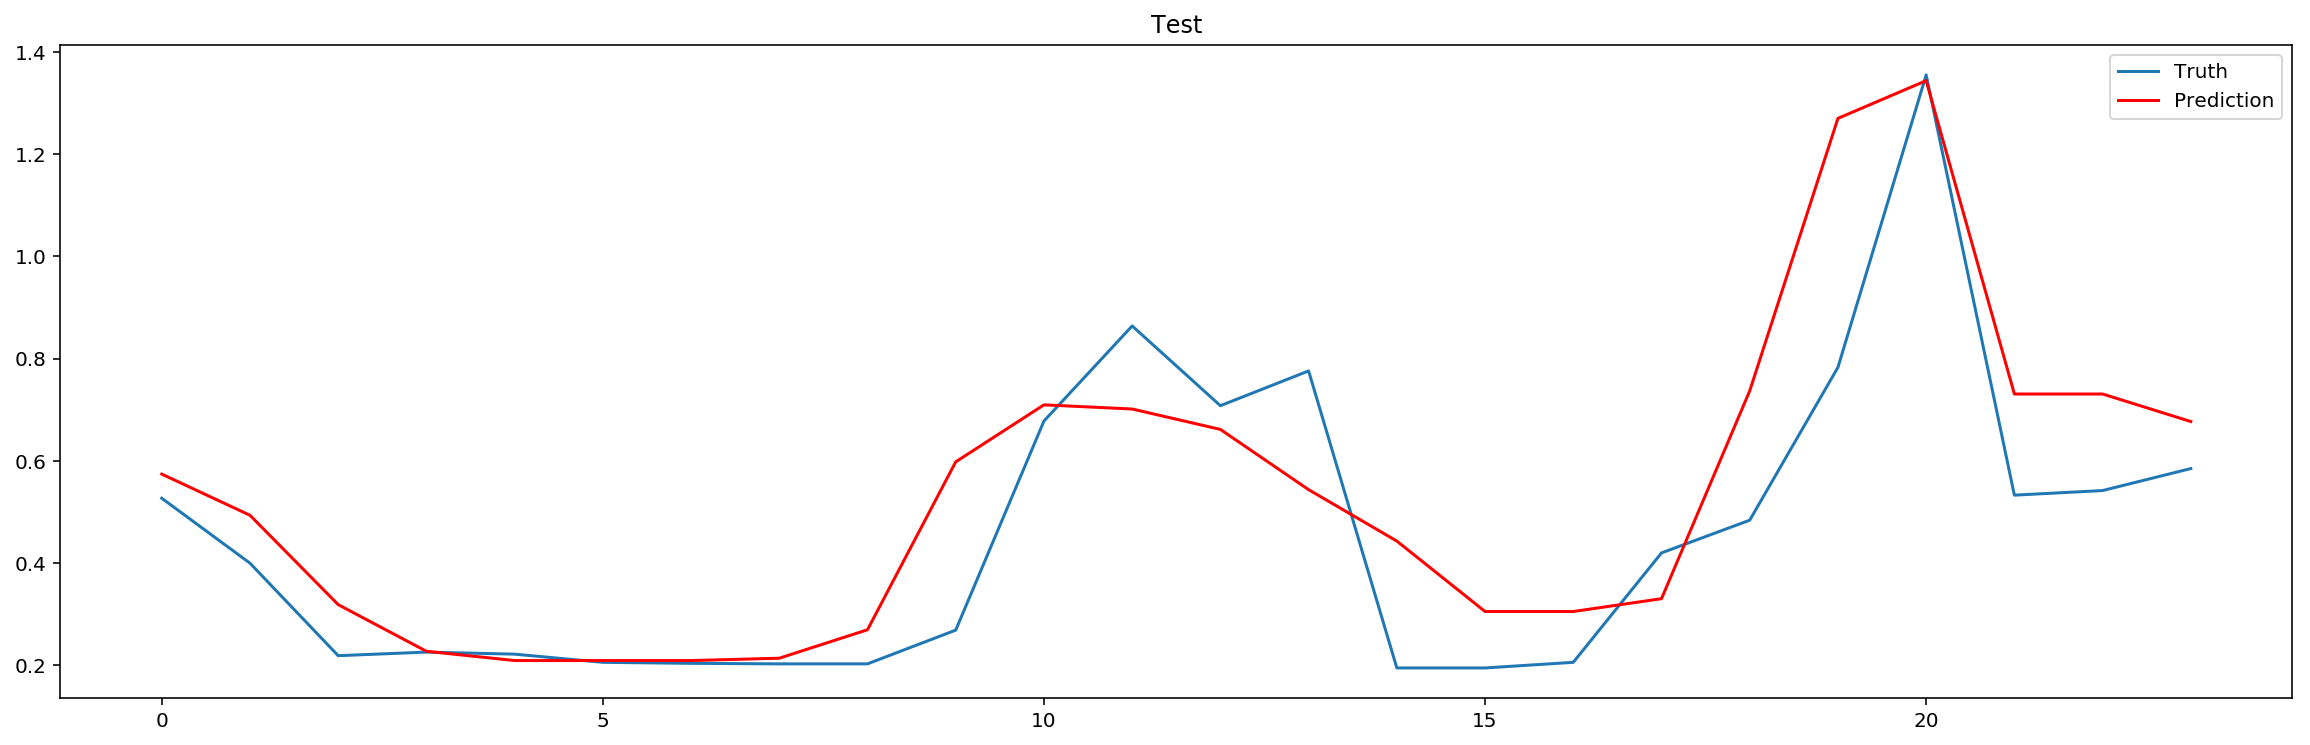

R-squared for Train: 0.43
R-squared for Test: 0.65


In [39]:
X_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['hour', 'weekday']]
y_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['energy']]
yHat_test_gbrt = gbrt.predict(X_test)

print (smape(yHat_test_gbrt, y_test.values))

plt.plot(y_test['energy'].values)
plt.plot(yHat_test_gbrt, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Test")
plt.show()

print ("R-squared for Train: %.2f" %gbrt.score(X_train, y_train))
print ("R-squared for Test: %.2f" %gbrt.score(X_test, y_test))



In [27]:
def prepare_train_test(df, y, features, n_in, n_out, current_step, step_foreward):
    step = current_step * step_foreward
    start_train = step
    end_train = n_in + step
    X_train = df[start_train:end_train][features]
    y_train = df[start_train:end_train][y]
    
    start_test = end_train
    end_test = start_test + n_out
    X_test = df[start_test:end_test][features]
    y_test = df[start_test:end_test][y]
    return X_train, y_train, X_test, y_test

def n_possible_steps(df, n_in, n_out, step_foreward):
    timesteps = df.shape[0]
    return int((timesteps - n_in - n_out) / step_foreward)


def rolling_forecast_experiment(df, y, features, n_in, n_out, step_foreward): 
    n_steps = n_possible_steps(df, n_in, n_out, step_foreward)
    
    smape_values = []
    for i in range(0, n_steps):
        gbrt=GradientBoostingRegressor(n_estimators=100)
        X_train, y_train, X_test, y_test = prepare_train_test(df, y, features, n_in, n_out, i, step_foreward)
        gbrt.fit(X_train, y_train)
        yHat = gbrt.predict(X_test)
        smape_values.append(smape(yHat, y_test.values))
    return smape_values


In [28]:
#Parameters for rolling forecast
y = ['energy']
features = ['hour', 'weekday']
n_in = h_params['n_in']
n_out = h_params['n_out'] 

#Perform Rolling Forecast 
smape_values = rolling_forecast_experiment(df_energy, y, features, n_in, n_out, n_out)
np.median(smape_values)

34.91228683367635

In [29]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday

y = ['energy']
features = ['hour', 'weekday', 'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure', 'apparentTemperature', 'windSpeed', 'humidity']
n_in = h_params['n_in']
n_out = h_params['n_out']

# Perform Rolling Forecast 
smape_values = rolling_forecast_experiment(df, y, features, n_in, n_out, n_out)
np.median(smape_values)

35.8917610801341

# KNeighborsRegressor

sMAPE 14.762112000186406


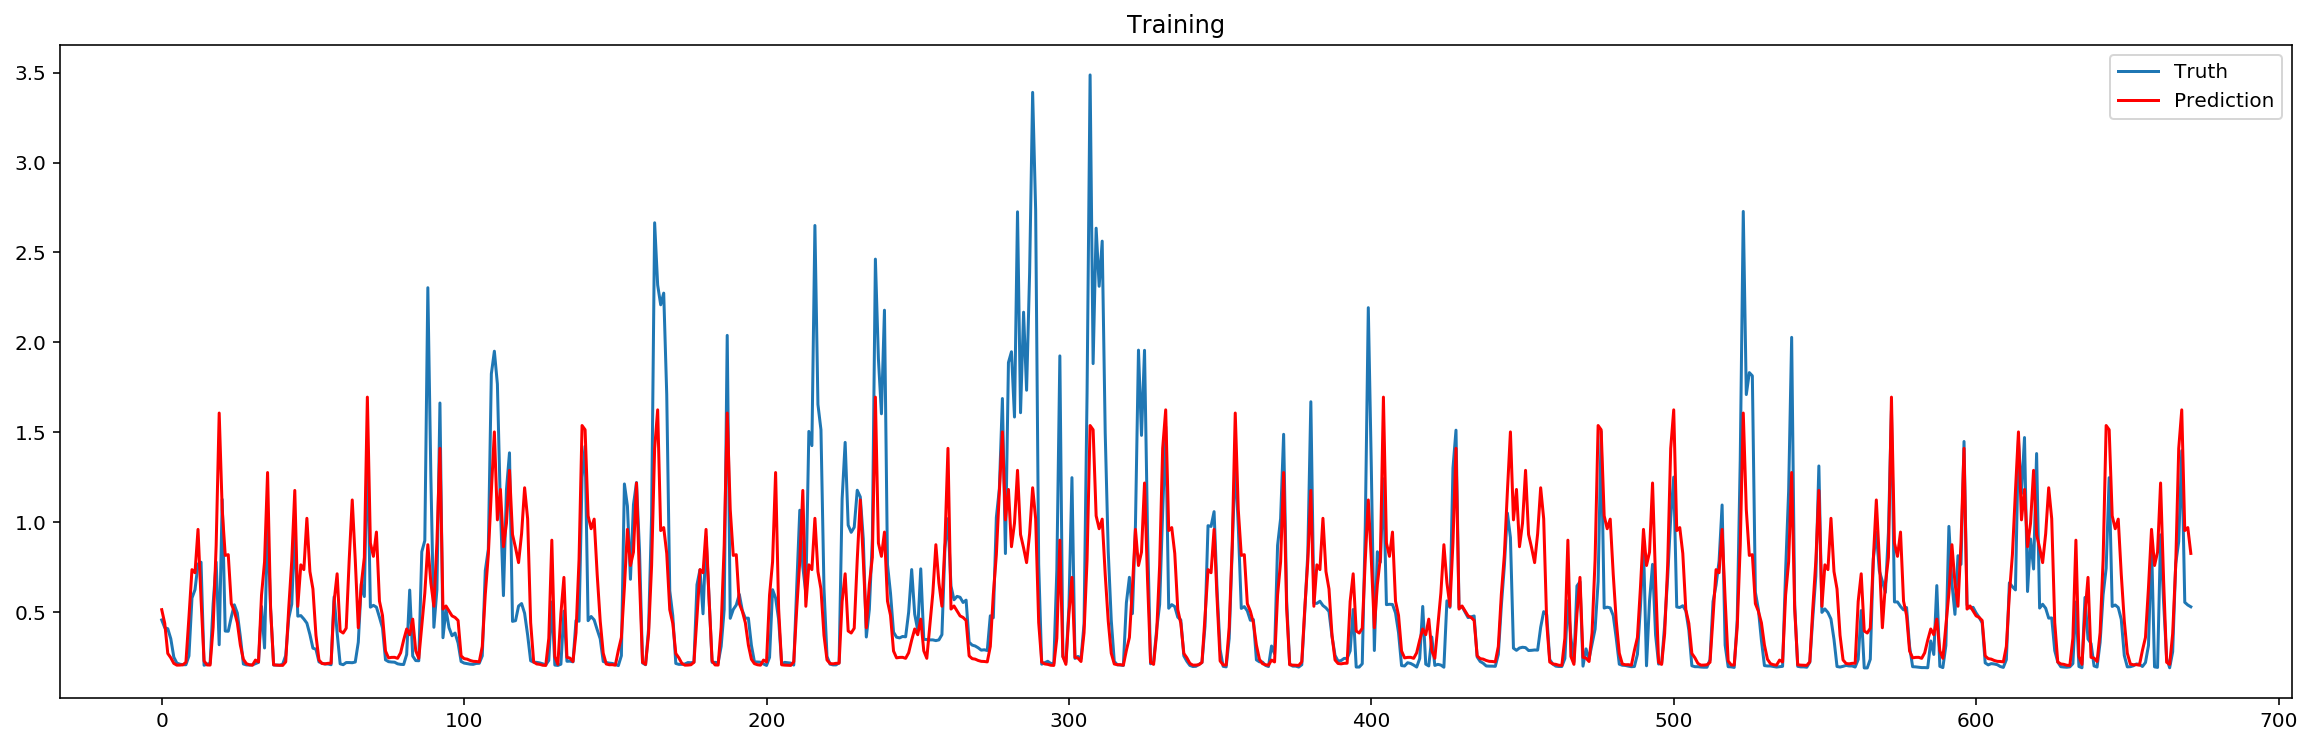

In [47]:
from sklearn.neighbors import KNeighborsRegressor

df_energy = df[['energy']]
df_energy['hour'] = df_energy.index.hour
df_energy['weekday'] = df_energy.index.weekday

X_train = df_energy[:h_params['n_in']][['hour', 'weekday']]
y_train = df_energy[:h_params['n_in']][['energy']]

n_neighbors = 100
neigh = KNeighborsRegressor(n_neighbors,weights = 'distance')
neigh.fit(X_train, y_train)
yHat_train_neigh = neigh.predict(X_train)

def smape(yHat, y):
    return np.mean(np.abs((yHat - y) / (y + yHat))) * 100

def mape(yHat, y):
    return np.mean(np.abs((y - yHat) / y)) * 100

print ('sMAPE' , smape(yHat_train_neigh, y_train.values))

plt.plot(y_train['energy'].values)
plt.plot(yHat_train_neigh, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Training")
plt.show()

9.583788859623239


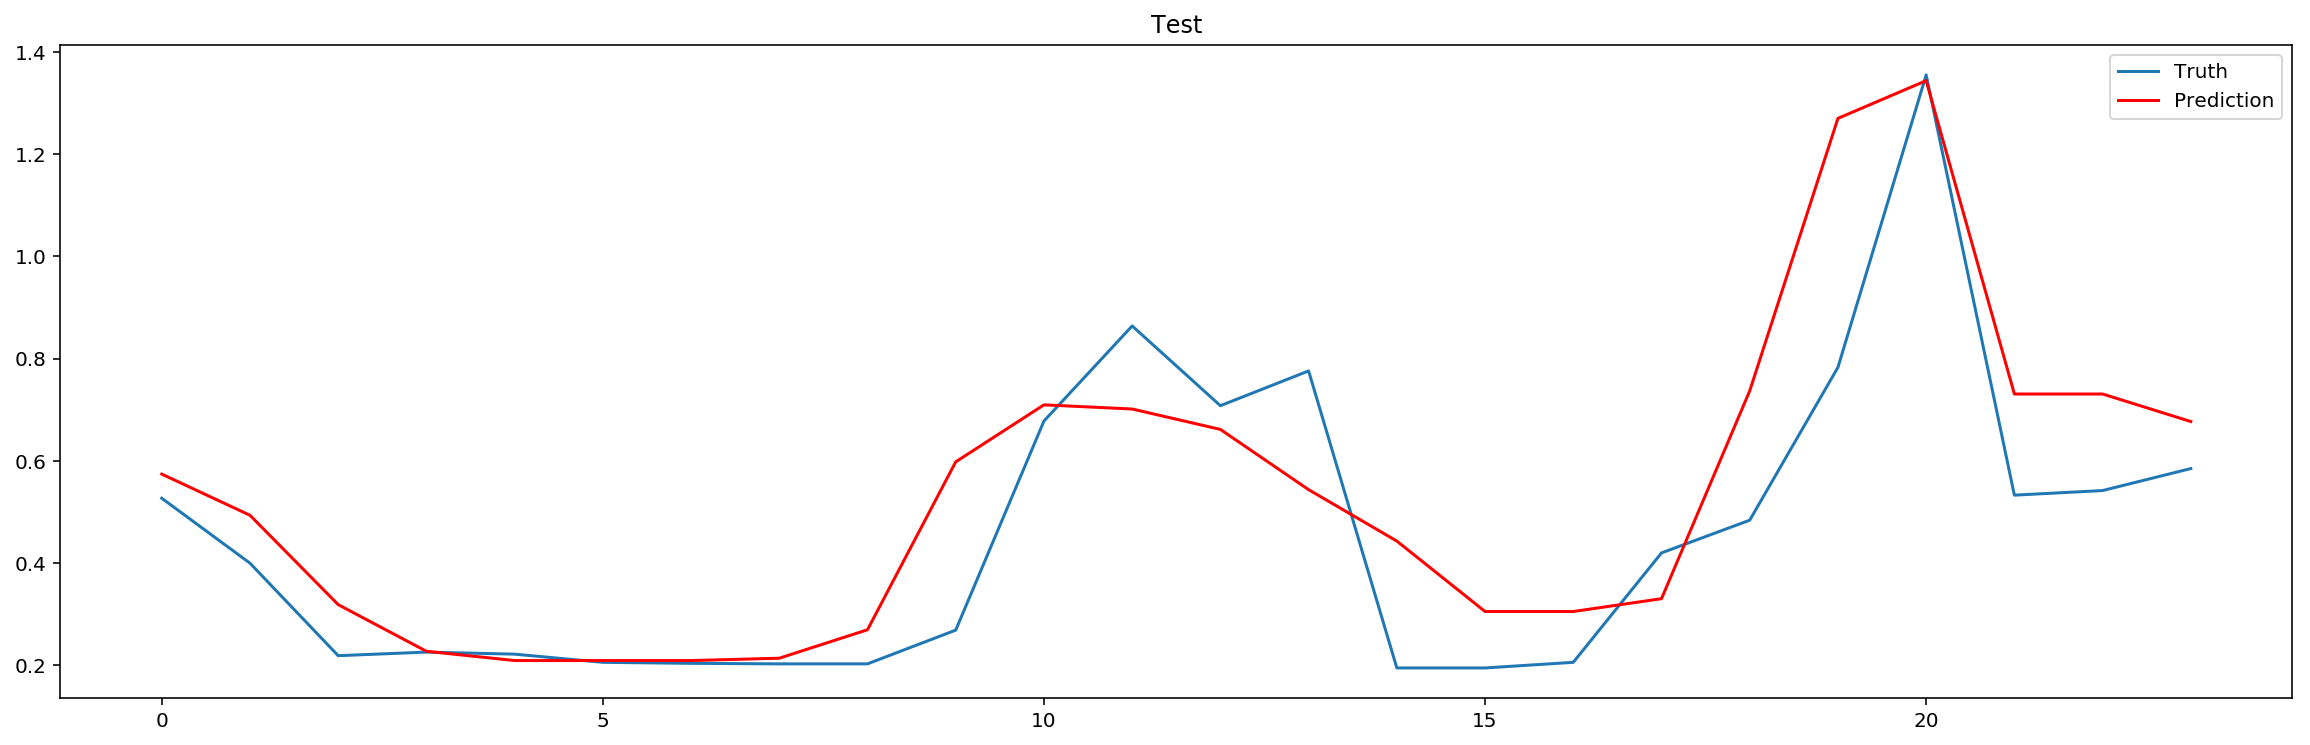

R-squared for Train: 0.49
R-squared for Test: 0.37


In [50]:
X_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['hour', 'weekday']]
y_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['energy']]
yHat_test_neigh = neigh.predict(X_test)

print (smape(yHat_test_neigh, y_test.values))

plt.plot(y_test['energy'].values)
plt.plot(yHat_test_gbrt, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Test")
plt.show()

print ("R-squared for Train: %.2f" %neigh.score(X_train, y_train))
print ("R-squared for Test: %.2f" %neigh.score(X_test, y_test))

In [57]:
def prepare_train_test(df, y, features, n_in, n_out, current_step, step_foreward):
    step = current_step * step_foreward
    start_train = step
    end_train = n_in + step
    X_train = df[start_train:end_train][features]
    y_train = df[start_train:end_train][y]
    
    start_test = end_train
    end_test = start_test + n_out
    X_test = df[start_test:end_test][features]
    y_test = df[start_test:end_test][y]
    return X_train, y_train, X_test, y_test

def n_possible_steps(df, n_in, n_out, step_foreward):
    timesteps = df.shape[0]
    return int((timesteps - n_in - n_out) / step_foreward)


def rolling_forecast_experiment(df, y, features, n_in, n_out, step_foreward): 
    n_steps = n_possible_steps(df, n_in, n_out, step_foreward)
    
    smape_values = []
    for i in range(0, n_steps):
        neigh = KNeighborsRegressor(n_neighbors,weights = 'distance')
        X_train, y_train, X_test, y_test = prepare_train_test(df, y, features, n_in, n_out, i, step_foreward)
        neigh.fit(X_train, y_train)
        yHat = neigh.predict(X_test)
        smape_values.append(smape(yHat, y_test.values))
    return smape_values


In [58]:
#Parameters for rolling forecast
y = ['energy']
features = ['hour', 'weekday']
n_in = h_params['n_in']
n_out = h_params['n_out'] 

#Perform Rolling Forecast 
smape_values = rolling_forecast_experiment(df_energy, y, features, n_in, n_out, n_out)
np.median(smape_values)

16.159519370340483

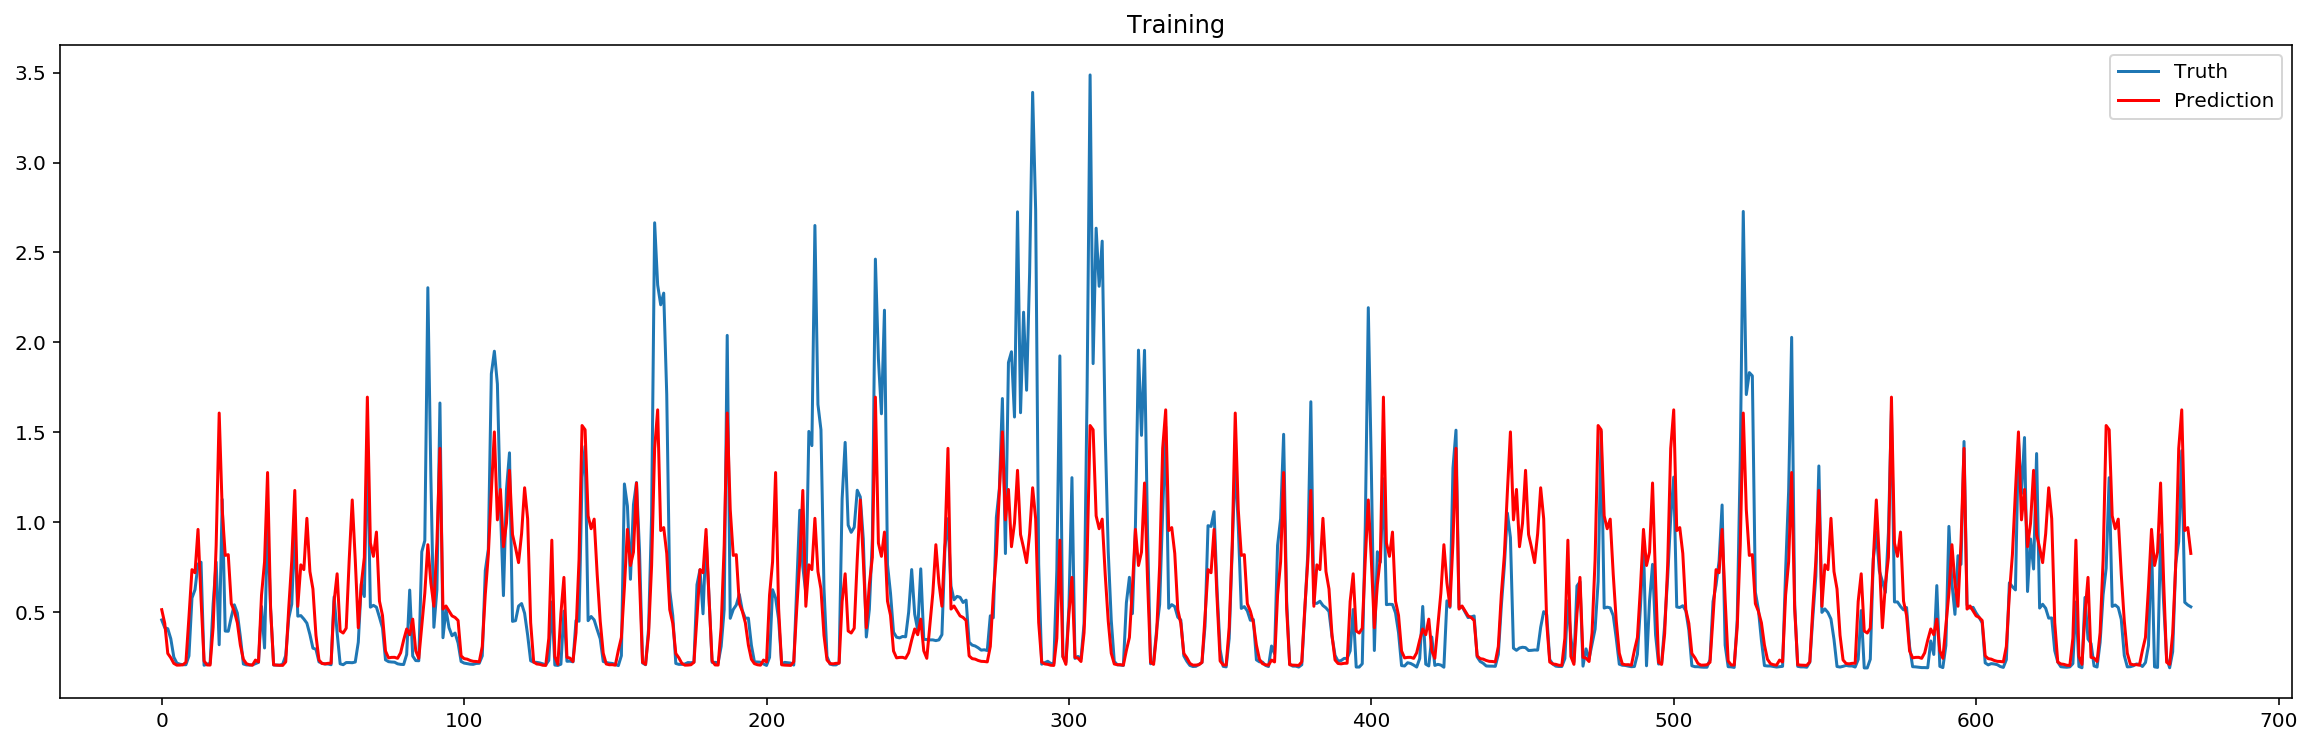

In [42]:
df_energy = df[['energy']]
df_energy['hour'] = df_energy.index.hour
df_energy['weekday'] = df_energy.index.weekday

X_train = df_energy[:h_params['n_in']][['hour', 'weekday']]
y_train = df_energy[:h_params['n_in']][['energy']]

def smape(yHat, y):
    return np.mean(np.abs((yHat - y) / (y + yHat))) * 100

def mape(yHat, y):
    return np.mean(np.abs((y - yHat) / y)) * 100

models = []
models.append(('QRF', RandomForestQuantileRegressor(random_state=0)))
models.append(('KRR', KernelRidge(kernel='rbf', gamma=0.1))) 
models.append(('SVR', SVR(kernel='rbf', C=0.2, gamma=0.7))) 
models.append(('GBR', GradientBoostingRegressor(n_estimators=100))) 
models.append(('KNR', KNeighborsRegressor(n_neighbors=100 ,weights = 'distance'))) 

results = []
names = []

for name , model in models:
    
    model.fit(X_train, y_train)
    yHat = model.predict(X_train)
    
    results.append((name , smape(yHat, y_train.values)))
    
plt.plot(y_train['energy'].values)
plt.plot(yHat, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Training")
plt.show()



In [24]:
results

[('QRF', 34.17391611680816),
 ('KRR', 18.64250096536558),
 ('SVR', 31.50718115705927),
 ('GBR', 33.511639417780025),
 ('KNR', 14.762112000186406)]

In [40]:
# hyperparameter selection for SVR

from sklearn import grid_search, svm

def svc_param_selection(X, y, nfolds):
    Cs = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,1,10]
    gammas = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1, 10]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVR(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X_train, y_train)
    grid_search.best_params_
    return grid_search.best_params_

print ('HyperParameters SVR' , svc_param_selection(X_train, y_train,2))

HyperParameters SVR {'C': 0.2, 'gamma': 0.7}
